In [1]:
import pandas as pd
import numpy as np
import scipy.signal
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import itertools
import math

<center><h1>Trabajo Practico N2</h1></center>

<h1>Primer Punto</h1>
<h2>Levantando los datos</h2>

<blockquote>
    <p> Los datasets los transformamos a formato .hdf para acelerar la entrada. El script utilizado para realizar la transformación se encuentra en este directorio y es: <a href="https://github.com/BrianBohe/DataScienceCourse/blob/master/tp2/super_acomodador_3000_de_muchos_datos.py">super_acomodador_3000_de_muchos_datos.py</a>. Generamos dos vectores de DataFrames, uno por cada grupo de personas:
    <ul>
        <li>Personas con capacidades cognitivas severamente disminuidas (<i>pacientes_P</i>)</li>
        <li>Personas con capacidad cognitiva normal (<i>pacientes_S</i>)</li>
    </ul>
    
    <p>Sólo trabajaremos con los electrodos en el conjunto {8,44,80,131,185}
    
    
</blockquote>

In [2]:
path = "datos"
load_path = path + "/{}.hdf"
electrodos = [8, 44, 80, 131, 185]

N_P = 10
N_S = 10
pacientes_P = []
pacientes_S = []
for load_name, N, dest, offset in [("P", N_P, pacientes_P, 0), ("S", N_S, pacientes_S, 10)]:
    for i in range(1, 1 + N):
        paciente = load_name + "{:02d}".format(i)
        df_ = pd.read_hdf(load_path.format(paciente))
        df_ = df_.loc[offset + i-1,:,electrodos,:]
        dest.append(df_)

<h2>Primera vista de los datos</h2>

<blockquote>
<p>La información quedó cargada como multi-índice.
</blockquote>

In [3]:
pacientes_S[0].head()

valores
paciente epoch sensor tiempo              
10       0     8      0       2.123794e-06
                      1      -1.335104e-06
                      2      -3.321541e-06
                      3      -1.837935e-06
                      4       2.672972e-07

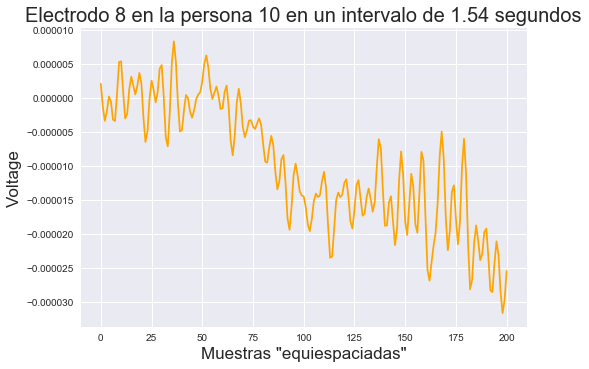

In [4]:
df_primer_plot = np.array(pacientes_S[0].loc[10,0,8,:])
sns.plt.plot(range(len(df_primer_plot)),df_primer_plot, color="orange", label="fasdfsadf")
sns.plt.ylabel('Voltage', fontsize=17)
sns.plt.xlabel('Muestras "equiespaciadas"', fontsize=17)
sns.plt.title('Electrodo 8 en la persona 10 en un intervalo de 1.54 segundos', fontsize=20)
## Podriamos marcar el estimulo: sns.plt.axvline(x=25, color='grey', linestyle='--')
sns.plt.show()

<h2>Ejercicio 1 - Análisis de Frecuencias</h2>

<blockquote>
    <p>Nuestros datos de entrada presentan 201 muestras por cada Paciente-Sensor-Epoch con frecuencia de 250 Hz. 
</blockquote>

<h3>Ejercicio 1 - A</h3>
<blockquote>
    <p>Potencia de las Frecuencias para cada Epoch de cada Paciente.
</blockquote>

In [5]:
# Me quedo con los sensores [8,44,80,131,185] de cada paciente
dfs1 = [pacientes_P[i].loc[i,:,[8,44,80,131,185],:] for i in range(N_P)] + \
    [pacientes_S[i].loc[i + 10,:,[8,44,80,131,185],:] for i in range(N_S)]

In [6]:
# Para cada paciente, promedio los voltages de todos los sensores 
#   agrupando por epoch y tiempo .
sensor_means = [df.groupby(['epoch', 'tiempo']).mean() for df in dfs1]

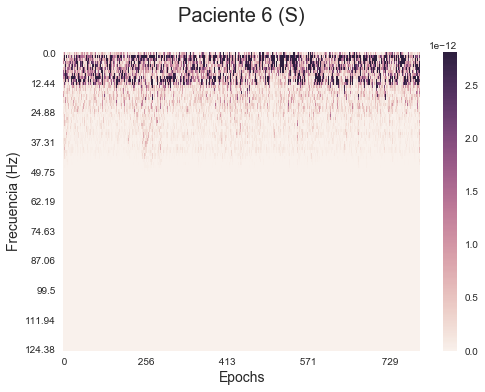

In [7]:
indice_persona = 1
esta_persona_tiene_capacidad_cognitiva_disminuida = True
capacidad_cognitiva = "P"#"capacidad cognitiva disminuida"

def copy_index_rounded_by_two_decimals(algunosValoresConMuchosDecimales):
    valoresRedondeados = []
    for i in range(len(algunosValoresConMuchosDecimales)):
        valoresRedondeados.append(round(algunosValoresConMuchosDecimales[i],2))
    return valoresRedondeados

def graficar_heatmap_potencia_frencuencia_por_epoch_para_los_datos_de_esta_persona(datos,persona, capacidad_cognitiva):
    frecuencias = datos.groupby(['epoch']).apply(lambda x: scipy.signal.welch(x['valores'], fs=250, nperseg = 201))
    data = {' {}'.format(i): f for i,f in enumerate(map(lambda x: x[1], frecuencias.values))}
    index = copy_index_rounded_by_two_decimals(frecuencias.values[0][0])
    f_df = pd.DataFrame(data=data, index=index)
    
    g = sns.heatmap(f_df, xticklabels=175, yticklabels=10, robust=True)
    
        
    sns.plt.title('Paciente {} ({})'.format(persona, capacidad_cognitiva), fontsize=20, y=1.08)
    sns.plt.ylabel('Frecuencia (Hz)', fontsize=14)
    sns.plt.xlabel('Epochs', fontsize=14)
    ## Descomentar esto para reducir el rango de Frecuencias de 0 a 50 como en el enunciado
    # axes = sns.plt.gca()
    # axes.set_ylim([60,101])
    sns.plt.show()

## Descomentar para poder ver todos
#
#for sm in sensor_means:
#    
#    if indice_persona > 10 and esta_persona_tiene_capacidad_cognitiva_disminuida:
#        esta_persona_tiene_capacidad_cognitiva_disminuida = False
#        indice_persona = 1
#        capacidad_cognitiva = "S"#"capacidad cognitiva normal"
#    
#    graficar_heatmap_potencia_frencuencia_por_epoch_para_los_datos_de_esta_persona(sm,indice_persona,capacidad_cognitiva)
#    
#    indice_persona+=1
    
## Dejo uno de muestra
graficar_heatmap_potencia_frencuencia_por_epoch_para_los_datos_de_esta_persona(sensor_means[15],6,"S")


<h3>Ejercicio 1 - A Bis</h3>
<blockquote>
    <p>Calcular la potencia media (entre epochs) para cada frecuencia y graficar la potencia en funcion de la frecuencia para cada canal.
</blockquote>

In [8]:
# Para cada paciente con capacidad cognitiva reducida,
#  promedio los voltages agrupando por sensor y tiempo .
epoch_means = [df.groupby(['sensor', 'tiempo']).mean() for df in pacientes_P]

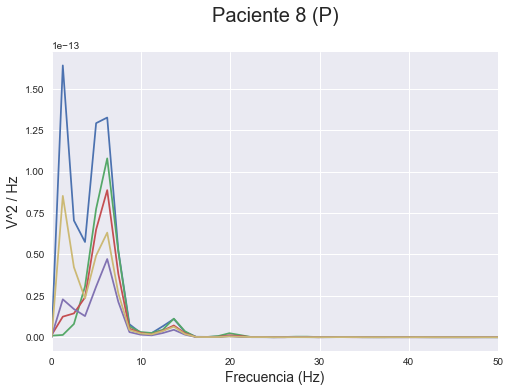

In [9]:
def graficar_potencia_media_para_cada_frecuencia_en_func_de_la_frecuencia(datos,persona):
    for sensor, df_g in datos.groupby(['sensor']):
        f, P = scipy.signal.welch(df_g['valores'].values, fs=250, nperseg=201)
        sns.plt.plot(f, P)#, xtitle="sensor {}".format(sensor))
    axes = sns.plt.gca()
    axes.set_xlim([0,50])
    sns.plt.title('Paciente {} (P)'.format(persona), fontsize=20, y=1.08)
    sns.plt.ylabel('V^2 / Hz', fontsize=14)
    sns.plt.xlabel('Frecuencia (Hz)', fontsize=14)

    sns.plt.show()

    
## Descomentar Para graficar todos
# 
#indice_persona = 1
#for em in epoch_means:
#    graficar_potencia_media_para_cada_frecuencia_en_func_de_la_frecuencia(em, indice_persona)
#    indice_persona+=1

## Dejamos uno solo de muestra
graficar_potencia_media_para_cada_frecuencia_en_func_de_la_frecuencia(epoch_means[7], 8)



<h3>Ejercicio 1 - B</h3>
<blockquote>
    <p>Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada paciente.
</blockquote>

In [10]:
def calcular_frecuencias(f, P):
    return {
        'delta': P[f<4].sum(),
        'theta': P[(4<=f) & (f<8)].sum(),
        'alpha': P[(8<=f) & (f<13)].sum(),
        'beta': P[(13<=f) & (f<30)].sum(),
        'gamma': P[30<=f].sum()
    }
    

bandas_P = []
bandas_S = []
for bandas, pacientes in [(bandas_P, pacientes_P), (bandas_S, pacientes_S)]:
    for i, p in enumerate(pacientes):
        frecuencia_media = p.groupby(['tiempo']).mean()
        f, P = scipy.signal.welch(frecuencia_media['valores'], fs=250, nperseg=201)
        bandas.append(calcular_frecuencias(f,P))


In [11]:
# Paciente Con Capacidad Cognitiva Normal 1
bandas_S[0]

{'alpha': 8.9619086982857224e-15,
 'beta': 1.3686577457693616e-14,
 'delta': 2.2436288714054142e-13,
 'gamma': 6.0067389463493581e-15,
 'theta': 1.4218145998494083e-13}

<h3>Ejercicio 1 - C</h3>
<blockquote>
    <p>Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn.
</blockquote>

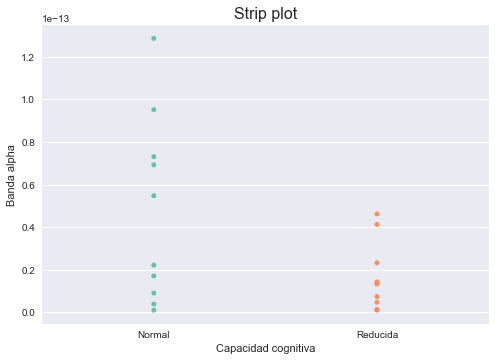

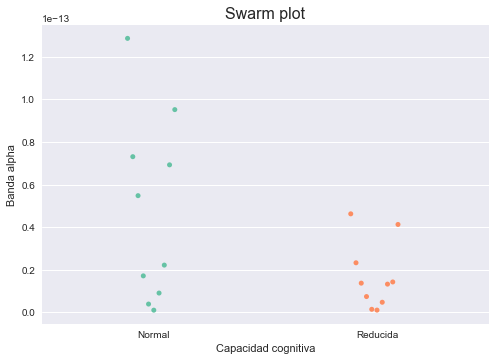

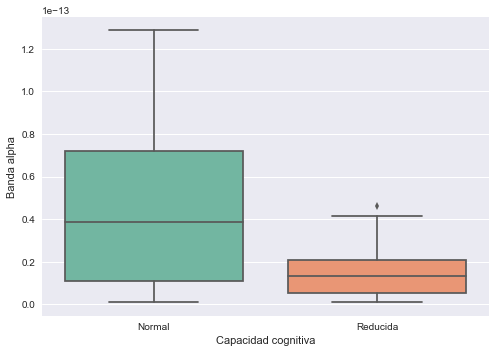

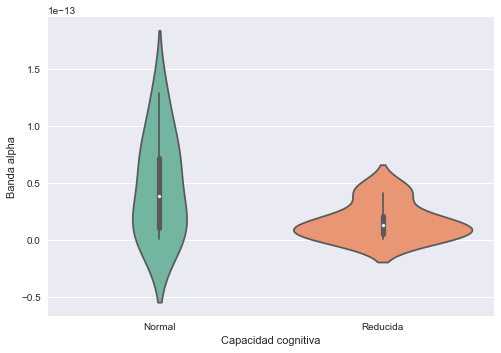

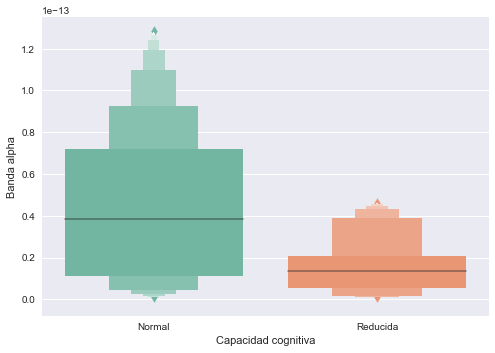

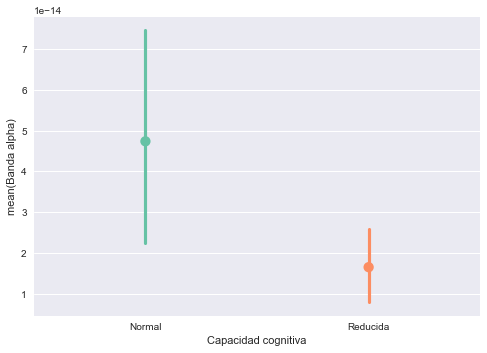

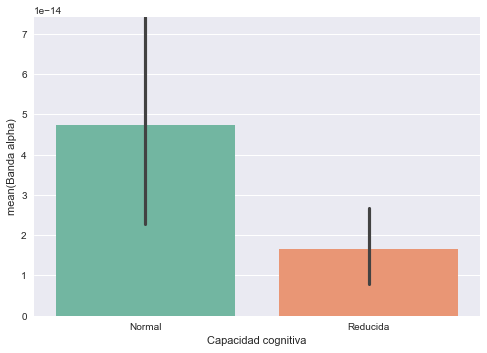

In [12]:
df_bandas = pd.DataFrame({
    "Capacidad cognitiva": (["Normal"] * N_S) + (["Reducida"] * N_P),
    "Banda delta": [d['delta'] for d in bandas_S + bandas_P],
    "Banda theta": [d['theta'] for d in bandas_S + bandas_P],
    "Banda alpha": [d['alpha'] for d in bandas_S + bandas_P],
    "Banda beta": [d['beta'] for d in bandas_S + bandas_P],
    "Banda gamma": [d['gamma'] for d in bandas_S + bandas_P],
})

ymin = min(df_bandas['Banda alpha'])
ymax = max(df_bandas['Banda alpha'])
decimo = (ymax - ymin)/len(df_bandas['Banda alpha'])
ymin, ymax = ymin - decimo, ymax + decimo

ax = sns.stripplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas, palette="Set2")
ax.set_ylim([ymin, ymax])
ax.set_title("Strip plot", fontsize=16)
#sns.plt.title('Paciente {} (P)'.format(indice_persona), fontsize=20, y=1.08)
sns.plt.show()

ax = sns.swarmplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas, palette="Set2")
ax.set_ylim([ymin, ymax])
ax.set_title("Swarm plot", fontsize=16)
sns.plt.show()

sns.boxplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas, palette="Set2")
ax.set_title("Box plot", fontsize=16)
sns.plt.show()

sns.violinplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas, palette="Set2")
ax.set_title("Violin plot", fontsize=16)
sns.plt.show()

sns.lvplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas, palette="Set2")
ax.set_title("Lette value plot", fontsize=16)
sns.plt.show()

sns.pointplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas, palette="Set2")
ax.set_title("Point plot", fontsize=16)
sns.plt.show()

sns.barplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas, palette="Set2")
ax.set_title("Bar plot", fontsize=16)
sns.plt.show()



<blockquote>
<p>Los plots <b>violinplot</b> y <b>swarmplot</b> parecen ser los más apropiados para visualizar las diferencias: el primero permite entender la distribución de los elementos, mientras que con el segundo se ven los valores puntuales. Por esta razón se utlizarán estos tipos de gráficos de ahora en más
</blockquote>

<h3>Ejercicio 1 - D</h3>
<blockquote>
    <p>Realizamos una comparación de las potencias de cada banda de frecuencia promediando los pacientes por capacidad cognitiva utilizando <b>Violin</b> y <b>Swarm</b>.</p>
    </br>
    <p>Planteamos un <i>Test de Permutación</i>
    <ul>
    <li><b>Hipótesis nula:</b> Los pacientes con Capacidades Cognitivas Normales (S) tienen igual o mayor potencia en la banda Delta que los pacientes con Capacidades Cognitivas Severamente Disminuidas.</li>
    <li><b>α-level:</b> 0.05</li>
    </ul>
</blockquote>

In [13]:
def calcular_delta(d,e):
    mean_1_inicial = d[e == e[0]].mean()
    mean_2_inicial = d[e != e[0]].mean()
    return mean_2_inicial - mean_1_inicial


def permutation_test(d,e, n=100):
    d0 = calcular_delta(d, e)
    deltas = np.zeros(n)
    aux_e = e.copy()

    for i in range(n):
        np.random.shuffle(aux_e)
        deltas[i] = calcular_delta(d,aux_e)

    return deltas, d0

def foo(a, e_a, b, e_b):
    e_1 = np.full(a.shape[0], e_a) 
    e_2 = np.full(b.shape[0], e_b)
    e = np.concatenate((e_1, e_2)) 
    d = np.concatenate((a,b))
    return d,e

def test_permutacion(cap_cog_reducida, cap_cog_normal ):
    d, e = foo(cap_cog_reducida, 'r', cap_cog_normal, 'n')

    # delta-value : la diferencia entre las medias que presenta nuestra información 
    # p-value es la probabilidad de haber obtenido este delta o mayor

    deltas, delta_value = permutation_test(d,e)
    p_value = deltas[deltas >= delta_value].shape[0]/deltas.shape[0]
    
    print("Delta-value = {} | p-value = {}".format(delta_value, p_value))
    
    return p_value
    
def realizar_test_no_parametrico_con_este_dataframe(df_b):
    p_values = {}
    for banda in ["delta", "theta", "alpha", "beta", "gamma"]:
        print("\t- Para la banda {}:".format(banda))
        p_values[banda] = \
            test_permutacion(df_b[(df_b['Banda'] == banda) & (df_b['Capacidad cognitiva'] == "Reducida")]['Potencia'],
                             df_b[(df_b['Banda'] == banda) & (df_b['Capacidad cognitiva'] == "Normal")]['Potencia'])
        print("\n")
    
def analisis_comparativo(df_b):
    ymin = min(df_b['Potencia'])
    ymax = max(df_b['Potencia'])
    decimo = (ymax - ymin)/len(df_b['Potencia'])
    ymin, ymax = ymin - decimo, ymax + decimo

    # Hay que tener en cuenta que son pocos valores

    ax = sns.violinplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", data=df_b,  split=True, palette="Set2", inner="stick", cut=0)
    sns.plt.show()

    ax = sns.swarmplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", data=df_b,  split=True, palette="Set2")
    ax.set_ylim([ymin, ymax])
    sns.plt.show()

    sns.barplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", data=df_b, palette="Set2")
    ax = sns.swarmplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", split=True, data=df_b, palette="Set2")
    ax.set_ylim([ymin, ymax])
    handles, labels = ax.get_legend_handles_labels()
    l = ax.legend(handles[:2], labels[:2])
    l.set_title("Capacidad cognitiva", prop = {'size':'small'})
    sns.plt.show()    

In [14]:
df_bandas = pd.DataFrame({
    "Capacidad cognitiva": (["Reducida"] * (N_P * 5)) + (["Normal"] * (N_S * 5)),
    "Banda": list(itertools.chain(*[list(d.keys()) for d in bandas_P + bandas_S])),
    "Potencia": list(itertools.chain(*[list(d.values()) for d in bandas_P + bandas_S]))
})

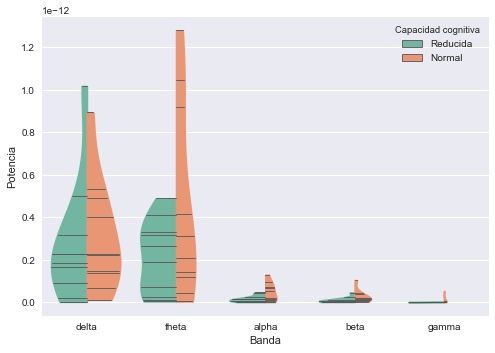

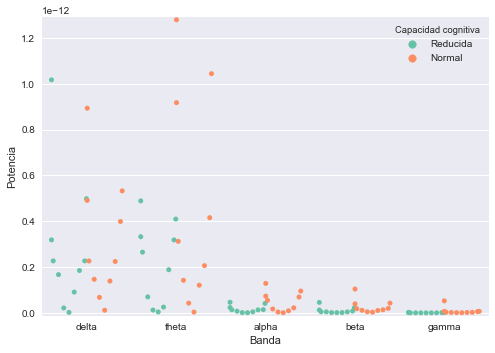

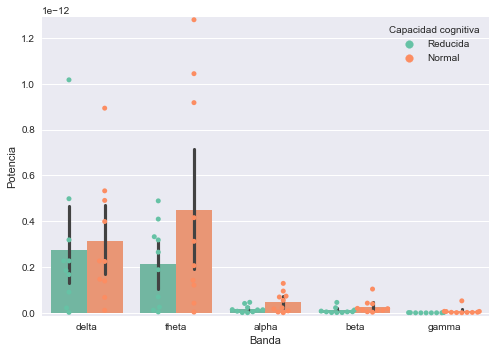

In [15]:
analisis_comparativo(df_bandas)

<blockquote>
    <p><b>Planteamos un <i>Test de Permutación</i>:</b>
    Nos interesa ver ver como se comportan las potencias de los pacientes con diferentes capacidades cognitivas.
    <ul>
    <li><b>Hipótesis nula:</b> Los pacientes con capacidades cognitivas normales (S) tienen igual o mayor potencia en la banda X que los pacientes con capacidades cognitivas reducidas (P). Con X alguna de nuestras bandas.</li>
    <li><b>α-level:</b> 0.05</li>
    </ul>
</blockquote>

In [16]:
realizar_test_no_parametrico_con_este_dataframe(df_bandas)

	- Para la banda delta:
Delta-value = 3.7692212496011094e-14 | p-value = 0.45


	- Para la banda theta:
Delta-value = 2.368771863587786e-13 | p-value = 0.05


	- Para la banda alpha:
Delta-value = 3.080676452062129e-14 | p-value = 0.01


	- Para la banda beta:
Delta-value = 1.6102991051229864e-14 | p-value = 0.04


	- Para la banda gamma:
Delta-value = 7.54893668417627e-15 | p-value = 0.0




<blockquote>
    <p>Hay información suficiente para rechazar <b>H0</b> en todos los casos salvo el de la banda delta.
</blockquote>

<blockquote>
    <p><b>Normalizando:</b> Ahora normalizamos los datos, realizamos una comparación con los mismos plots y volvemos a hacer el test.
    
    <p><b>Planteamos un <i>Test de Permutación</i>:</b>
    Nos interesa ver ver como se comportan las potencias de los pacientes con diferentes capacidades cognitivas.
    <ul>
    <li><b>Hipótesis nula:</b> Los pacientes con capacidades cognitivas normales (S) tienen igual o mayor potencia en la banda X que los pacientes con capacidades cognitivas reducidas (P). Con X alguna de nuestras bandas.</li>
    <li><b>α-level:</b> 0.05</li>
    </ul>
</blockquote>

In [17]:
def normalizar_banda(df_):
    min_pot = min(df_['Potencia'])
    max_pot = max(df_['Potencia'])
    
    df_["Potencia"] = (df_["Potencia"] - min_pot) / (max_pot - min_pot)
    
    return df_

------------
Análisis comparativo normalizado para las distintas bandas:


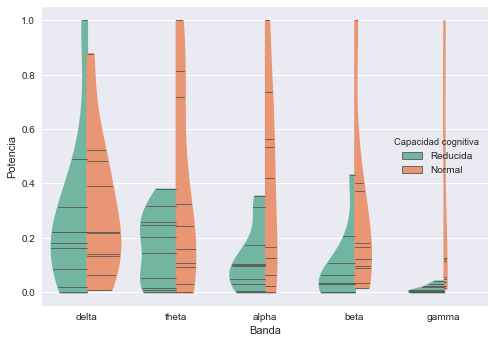

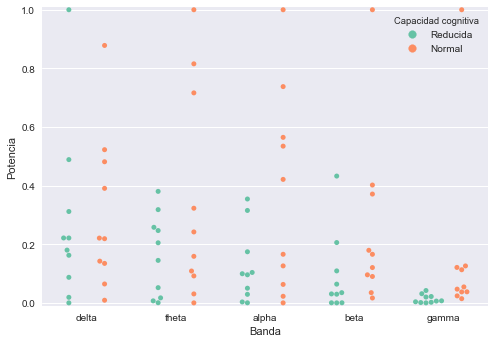

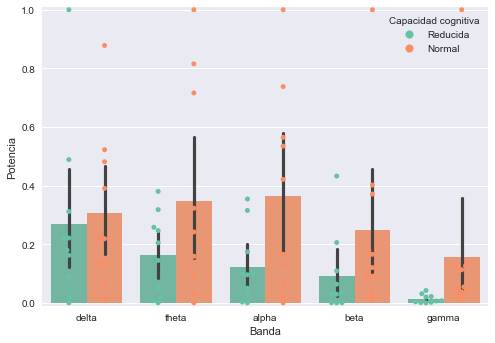

In [18]:
df_bandas_normalizadas = df_bandas.groupby(['Banda']).apply(normalizar_banda)
print("------------", "Análisis comparativo normalizado para las distintas bandas:", sep="\n")
analisis_comparativo(df_bandas_normalizadas)

In [19]:
realizar_test_no_parametrico_con_este_dataframe(df_bandas_normalizadas)

	- Para la banda delta:
Delta-value = 0.03715742006982803 | p-value = 0.4


	- Para la banda theta:
Delta-value = 0.18574796258282503 | p-value = 0.06


	- Para la banda alpha:
Delta-value = 0.24102243623667546 | p-value = 0.03


	- Para la banda beta:
Delta-value = 0.1569059357070198 | p-value = 0.04


	- Para la banda gamma:
Delta-value = 0.14395349821311632 | p-value = 0.0




<blockquote>
    <p>Al igual que antes, hay información suficiente para rechazar <b>H0</b> en los casos de las bandas gamma y beta, pero no hay suficiente información para hacer lo mismo en las demás.
</blockquote>

<h1>Segundo Punto</h1>

In [20]:
import pandas as pd
import numpy as np
import scipy.signal
import scipy.stats
import seaborn as sns
import matplotlib.ticker as ticker
import itertools
import math

In [21]:
path = "datos/"
load_path = path + "{}.hdf"

electrodos = [8, 44, 80, 131, 185]

N_P = 10
N_S = 10
pacientes_P = []
pacientes_S = []
for load_name, N, dest, offset in [("P", N_P, pacientes_P, 0), ("S", N_S, pacientes_S, 10)]:
    for i in range(1, 1 + N):
        paciente = load_name + "{:02d}".format(i)
        df_ = pd.read_hdf(load_path.format(paciente))
        df_ = df_.loc[offset + i-1,:,electrodos,:]
        dest.append(df_)

<h1>Análisis intra-electrodo</h1>
<h2>Discretizando el espacio de señales</h2>
<p>
Para poder aplicar alguno de los análisis propuestos en el enunciado es necesario discretizar el espacio de señales aplicando una transformación simbólica.
Para esto debe definirse una serie de rangos a los cuales asociaremos las distintas medidas de señales que tenemos.
Luego, se asocia a cada rango un símbolo de un alfabeto.
<p> La primer dificultad que surge es <b>cómo definir tal alfabeto</b>.
Inicialmente se trató de utilizar un único alfabeto para todos los electrodos por igual, tomando los valores máximos y mínimos de todos los datos, pero por la diferencia entre dichos valores la mayoría de las muestras caían en los mismos símbolos.
La siguiente figura ejemplifica el problema:

<img src="bins.png">

La solución a este problema fue tomar un alfabeto por cada electrodo con valores promediados. 
Se modela como fuente de información cada tupla (paciente, electrodo).

In [22]:
# Calculo de N (cantidad de bins): Se usa n = 201 porque los epochs tienen esa cantidad de muestras
def calculo_N(df_):
    return math.ceil((df_.max() - df_.min()) / (3.5*df_.std() * 201 ** (-1/3)))

pacientes = pd.concat(pacientes_P + pacientes_S)
val = pacientes.groupby(["sensor","epoch"])['valores'].mean()
i_s = pd.DataFrame({'sensor':electrodos})
i_s['N'] = val.groupby(["sensor"]).apply(calculo_N).values
i_s['min'] = val.groupby(["sensor"]).min().values
i_s['max'] = val.groupby(["sensor"]).max().values
i_s['step'] = (i_s['max'] - i_s['min']) / i_s['N']
i_s = i_s.set_index('sensor')
i_s

,N,min,max,step
sensor,,,,
8,16,-0.000015,0.000015,0.000002
44,18,-0.000020,0.000017,0.000002
80,17,-0.000019,0.000016,0.000002
131,15,-0.000016,0.000013,0.000002
185,16,-0.000015,0.000012,0.000002


El siguiente gráfico muestra las divisiones que se realizarían con esta nueva definición de alfabeto:

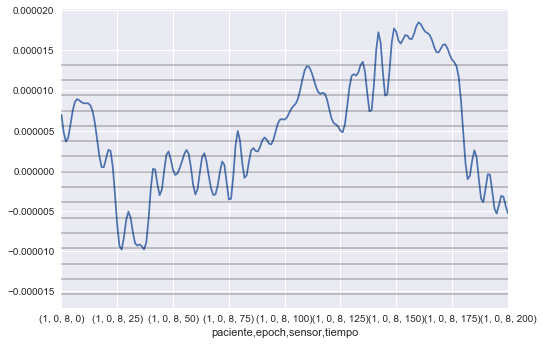

In [23]:
pacientes.loc[1,0,8,:]['valores'].plot()
for i in range(int(i_s.loc[8]['N'])):
    sns.plt.plot((0,200),(i_s.loc[8]['min'] + i*i_s.loc[8]['step'],i_s.loc[8]['min'] + i*i_s.loc[8]['step']),
                 'k-', lw = 0.4)
sns.plt.show()

In [24]:
def obtener_simbolo(v):
    sensor = v.reset_index().sensor[0]
    simbolo = (v - i_s.loc[sensor]['min']) // i_s.loc[sensor]['step']
    return simbolo
pacientes['simbolo'] = pacientes.groupby("sensor").apply(obtener_simbolo).values

<h2>Análisis de entropía</h2>
<p>
Una vez realizada la transformación simbólica ya es posible aplicar distitnas métricas para analizar cada uno de los electrodos.
En esta primera sección se decidió utilizar la entropía de cada electrodo para cada paciente.


In [25]:
# Calculo de probabilidad de cada símbolo. Cada paciente y sensor se considera una fuente de información distinta
pacientes['repeticiones'] = pacientes.groupby(["paciente", "sensor","simbolo"]).transform('count')['valores']
pacientes['total'] = pacientes.groupby(["paciente", "sensor"]).transform('count')['valores']
pacientes['probabilidad'] = pacientes['repeticiones'] / pacientes['total']
pacientes.head()

valores  simbolo  repeticiones     total  \
paciente epoch sensor tiempo                                                  
0        0     8      0      -2.156435e-06      6.0       20363.0  179694.0   
                      1      -5.516751e-07      7.0       24723.0  179694.0   
                      2       2.121832e-06      9.0       19780.0  179694.0   
                      3       4.735732e-06     10.0       13391.0  179694.0   
                      4       5.841685e-06     11.0        9081.0  179694.0   

                              probabilidad  
paciente epoch sensor tiempo                
0        0     8      0           0.113320  
                      1           0.137584  
                      2           0.110076  
                      3           0.074521  
                      4           0.050536

In [26]:
def calcular_entropia(df_):
    df_ = df_.groupby("simbolo").first()
    p = df_["probabilidad"]
    return -sum(p * np.log(p))

entropias_a = pacientes.groupby(["paciente","sensor"]).apply(calcular_entropia).reset_index()
entropias_a = entropias_a.rename(columns = {0:'Entropia', 'sensor': 'Sensor'})
entropias_a['Capacidad Cognitiva'] = (entropias_a.paciente < 10).apply(lambda x: 'Normal' if x else 'Reducida')

Se obtienen las siguientes distribuciones de entropía para cada tipo de paciente y para cada uno de los electrodos:

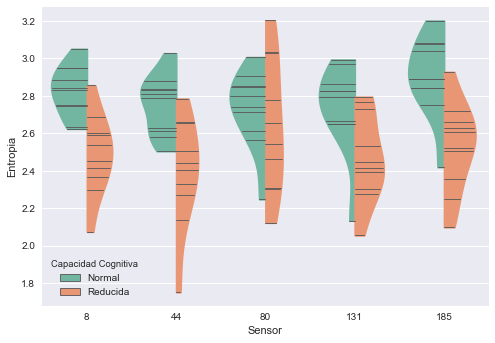

In [27]:
sns.violinplot(x="Sensor", y="Entropia", hue="Capacidad Cognitiva", data=entropias_a, 
               split=True, palette="Set2", inner="stick", cut=0)
sns.plt.show()

Destaca de inmediato como las distribuciones varían notablemente según el tipo de paciente.
Para verificar esto se plantea el siguiente test estadístico para cada electrodo, cuya hipótesis nula <b>HO</b> es que ambos grupos tienen la misma media de entropía y cuyo valor <b>alpha</b> es 0,05.

In [28]:
# Evaluo la media de información por sensor comparando los individuos con capacidad cognitiva reducida y normal
# Uso rank sum con hipótesis nula: "Ambas muestras tienen la misma media"

for s in electrodos:
    x = entropias_a[(entropias_a.Sensor == s) & (entropias_a['Capacidad Cognitiva'] == 'Reducida')].Entropia
    y = entropias_a[(entropias_a.Sensor == s) & (entropias_a['Capacidad Cognitiva'] != 'Reducida')].Entropia
    _, p = scipy.stats.ranksums(x,y)
    print('p-valor misma media para sensor {}: {}'.format(s,p))

p-valor misma media para sensor 8: 0.001498873337151676
p-valor misma media para sensor 44: 0.005158957570721309
p-valor misma media para sensor 80: 0.5453496680111236
p-valor misma media para sensor 131: 0.015564411386633814
p-valor misma media para sensor 185: 0.004071994217732759


Por los resultados de los tests se puede afirmar que hay distintas medias para los cinco electrodos en cuestión salvo el número 80.
Esto es evidencia de como ambos grupos difieren respecto del nivel de activación de los electrodos.

<h1>Análisis inter-electrodo</h1>
<h2>Definición del alfabeto</h2>
<p>
A diferencia del caso anterior, para realizar este análisis es necesario que todos los electrodos compartan el mismo alfabeto pues si no no serían comparables.
Las fuentes de información son cada uno de los electrodos promediados.

In [29]:
df_P = pd.concat(pacientes_P)
df_SP = df_P.groupby(["sensor","tiempo"]).mean()
df_S = pd.concat(pacientes_S)
df_SS = df_S.groupby(["sensor", "tiempo"]).mean()

In [30]:
# Calcular N para hacer la transformación simbólica
pacientes_b_mean = pd.concat(pacientes_P + pacientes_S).groupby(["sensor","tiempo"]).mean()
N_b = math.ceil(pacientes_b_mean.max() - pacientes_b_mean.min() / (pacientes_b_mean.std() * len(pacientes_b_mean) ** (-1/3)))
step_b = (pacientes_b_mean.max() - pacientes_b_mean.min()) / N_b

print(N_b, step_b)

29 valores    6.655843e-08
dtype: float64


El siguiente gráfico ilustra una división en símbolos para este análisis. 
Para simplificar la transformación simbólica a aquellas valores de intensidad que estén por arriba del límite superior les será asociado el último símbolo.
La idea análoga se aplica a aquellos que quedan por debajo del límite inferior.

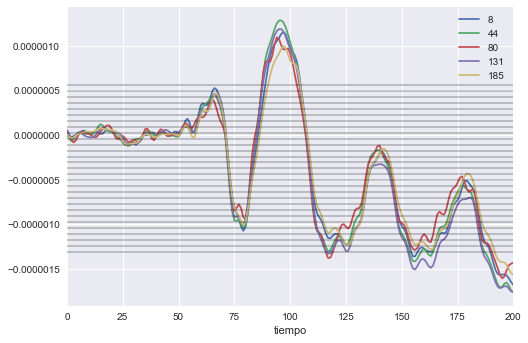

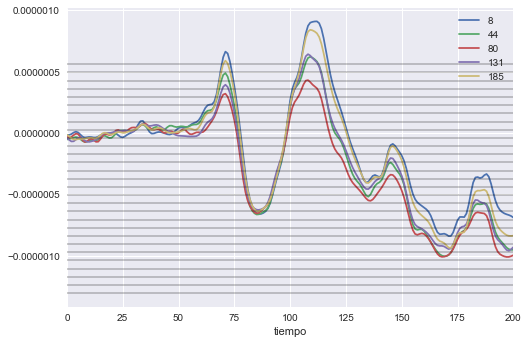

In [31]:
# Las lineas indican la separacion en símbolos
start_b = pacientes_b_mean.min()

fig, ax = sns.plt.subplots(1,1) 
df_SS.reset_index().groupby("sensor").plot(x="tiempo", y="valores", ax=ax)
sns.plt.legend([v[0] for v in df_SS.groupby('sensor')])
for i in range(N_b):
    sns.plt.plot((0,200),(start_b + i*step_b,start_b + i*step_b), 'k-', lw = 0.4)

sns.plt.show()

fig, ax = sns.plt.subplots(1,1) 
df_SP.reset_index().groupby("sensor").plot(x="tiempo", y="valores", ax=ax)
sns.plt.legend([v[0] for v in df_SP.groupby('sensor')])
for i in range(N_b):
    sns.plt.plot((0,200),(start_b + i*step_b,start_b + i*step_b), 'k-', lw = 0.4)

sns.plt.show()

In [32]:
# Asigno simbolos de acuerdo al valor
def obtener_simbolo_b(v):
    return (v - pacientes_b_mean.min()) // step_b
df_SS['simbolo'] = df_SS['valores'].apply(obtener_simbolo_b)
df_SP['simbolo'] = df_SP['valores'].apply(obtener_simbolo_b)

df_SP.head()

valores  simbolo
sensor tiempo                       
8      0      -1.612741e-08     19.0
       1      -1.618464e-08     19.0
       2      -9.173112e-09     19.0
       3       3.026673e-09     19.0
       4       1.021965e-08     19.0

In [33]:
df_SP['repeticiones'] = df_SP.groupby(["sensor","simbolo"]).transform('count')['valores']
df_SP['total'] = df_SP.groupby(["sensor"]).transform('count')['valores']
df_SP['probabilidad'] = df_SP['repeticiones'] / df_SP['total']
df_SS['repeticiones'] = df_SS.groupby(["sensor","simbolo"]).transform('count')['valores']
df_SS['total'] = df_SS.groupby(["sensor"]).transform('count')['valores']
df_SS['probabilidad'] = df_SS['repeticiones'] / df_SS['total']

df_SS.head()

valores  simbolo  repeticiones  total  probabilidad
sensor tiempo                                                          
8      0      -8.804419e-09     19.0          28.0  201.0      0.139303
       1      -2.458968e-08     19.0          28.0  201.0      0.139303
       2      -2.306229e-08     19.0          28.0  201.0      0.139303
       3      -1.044884e-08     19.0          28.0  201.0      0.139303
       4       3.611096e-09     19.0          28.0  201.0      0.139303

Una vez realizada la transformación símbolica, se decidió utilizar jointplots para comparar la relación entre las distintas variables que son los símbolos asociados a cada electrodo y a cada paciente.
<p>
Realizaremos dos tipos de comparaciones:
<ol>
    <li>Comparación entre individuos de distintos grupos</li>
    <li>Comparación entre individuos de mismos grupos</li>
</ol>
<p> Al realizar estas dos comparaciones se espera poder mostrar como la división de los individuos en estos dos grupos es significativa.

<h3>Comparación entre individuos de distintas capacidad cognitiva</h3>

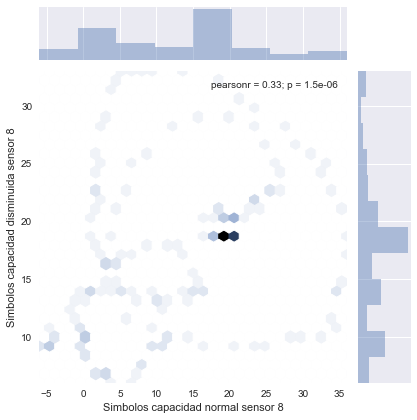

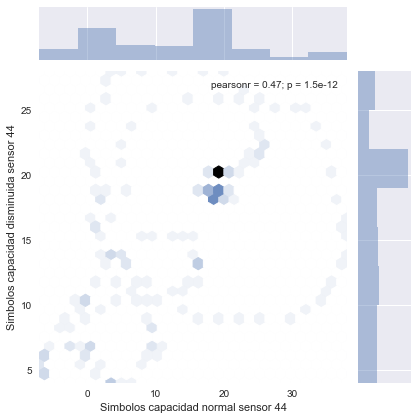

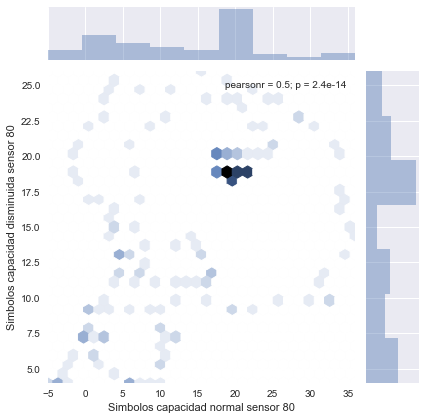

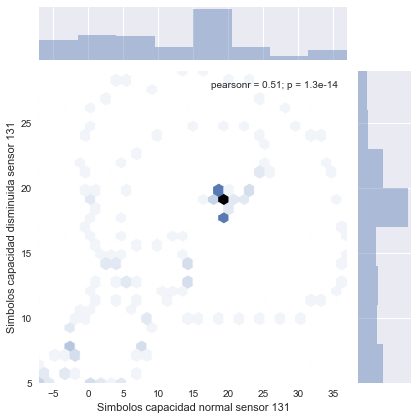

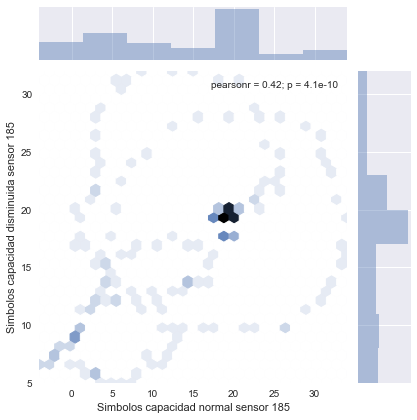

In [34]:

# Comparación de sensores entre personas con capacidad disminuida y normal
for e in electrodos:
    sensorX = df_SS.loc[e]['simbolo']
    sensorY = df_SP.loc[e]['simbolo']
    sns.jointplot(sensorX, sensorY, kind='hex', gridsize=30).set_axis_labels(
        "Simbolos capacidad normal sensor {}".format(e), "Simbolos capacidad disminuida sensor {}".format(e))

sns.plt.show()

<h3>Comparación entre individuos de capacidad cogintiva normal</h3>

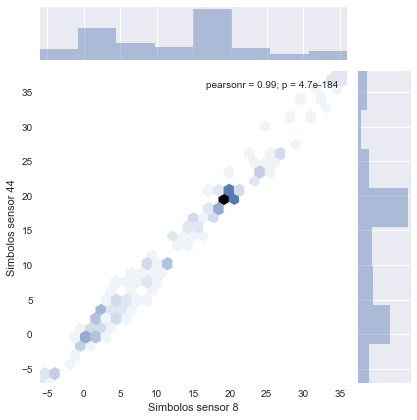

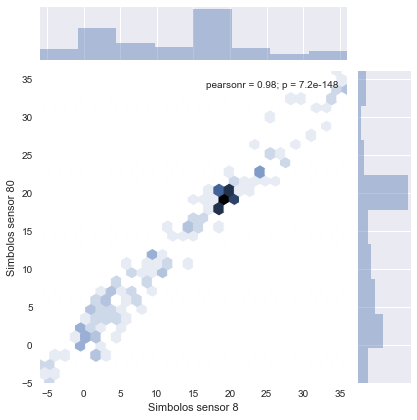

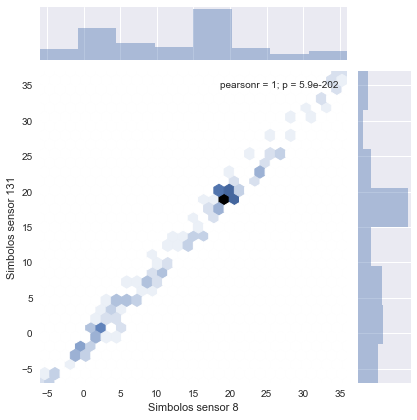

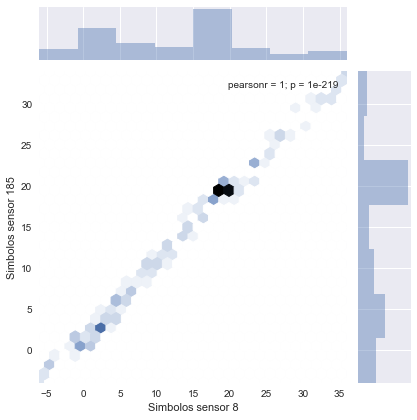

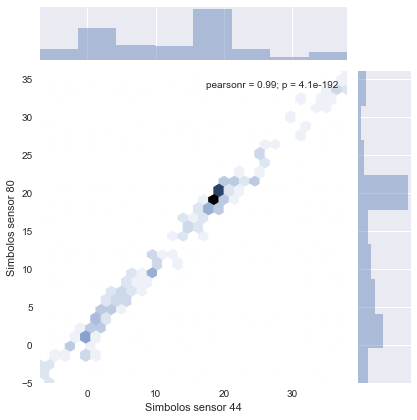

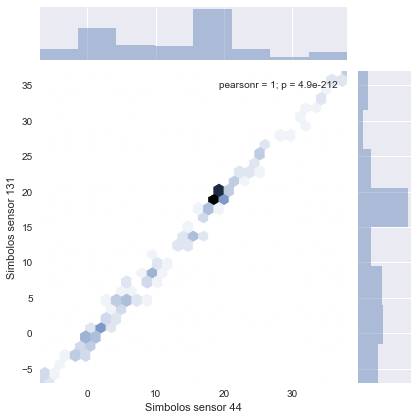

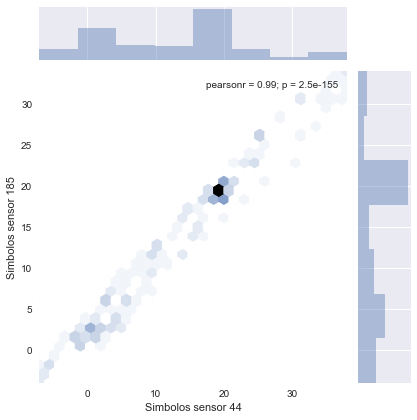

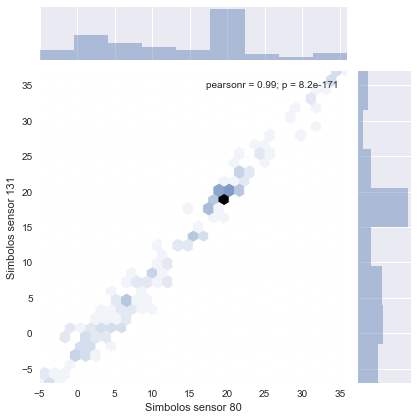

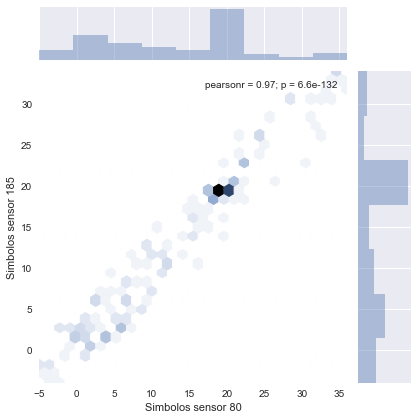

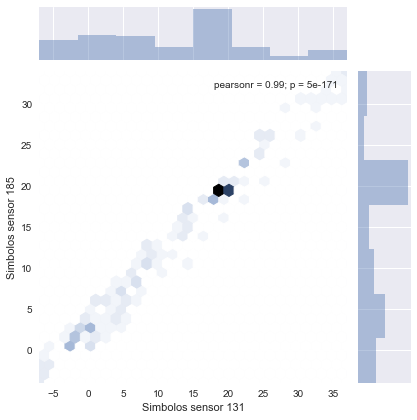

In [35]:
# Comparación de sensores distintos de personas con capacidad cognitiva normal
for i, e1 in enumerate(electrodos):
    for e2 in electrodos[i+1:]:
        sensorX = df_SS.loc[e1]['simbolo']
        sensorY = df_SS.loc[e2]['simbolo']
        sns.jointplot(sensorX, sensorY, kind='hex', gridsize=30).set_axis_labels(
            "Simbolos sensor {}".format(e1), "Simbolos sensor {}".format(e2))

sns.plt.show()

Del primer grupo de comparaciones se puede concluir que efectivamente las activaciones entre ambos grupos difieren. Con esta comparación se analizan las intensidades para el mismo electrodo pero distintos grupos. Se puede ver que las señales no están fuertemente corelacionadas (en particular el coeficiente de pearson está entre 0.3 y 0.5).
<p>
Por otro lado, si realizamos comparaciones entre las señales del mismo grupo (como es el caso del segundo grupo de comparaciones) podemos ver como las señales sí están fuertemente corelacionadas (coeficiente de pearson entre 0.97 y 1).
<p>
Estos dos resultados nos permiten concluir que ambos grupos son caracterizables según la activación de señal de los electrodos propuestos, lo que podría ser un punto de partida para establecer un algoritmo que permita identificar a cual de los dos grupos pertenece un nuevo individuo.